In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

# Часть первая, с блекджеком и стратегиями
1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
env = gym.make('Blackjack-v0', natural=True)

In [3]:
eval_episodes_num = 100_000

actions = {
    'stick': 0,
    'hit': 1
}

def play_simple_strategy(env):
    "Play episode in env with simple stategy"
    score, dealer_card, usable_ace = env.reset()
    while score < 19:
        observation, reward, done, info = env.step(actions['hit'])
        score, dealer_card, usable_ace = observation
    else:
        observation, reward, done, info = env.step(actions['stick'])
        score, dealer_card, usable_ace = observation
    return reward

rewards = np.array([play_simple_strategy(env) for i in tqdm(range(eval_episodes_num))])

print("Avg reward:", rewards.mean())


Avg reward: -0.042075


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Реализуем Q-обучение:

In [4]:
env = gym.make('Blackjack-v0', natural=True)
action_space_shape = [env.action_space.n]
observation_space_shape = [discrete_space.n for discrete_space in env.observation_space]
reward_range = [-1, 1]


def get_random_reward(reward_range, shape=None):
    return np.random.random(shape) * (reward_range[1] - reward_range[0]) + reward_range[0]


def get_random_Q():
    Q = get_random_reward(reward_range, shape=observation_space_shape + action_space_shape)
    Q[np.arange(observation_space_shape[0]) > 21] = -1
    Q[np.arange(observation_space_shape[0]) == 21] = 1
    return Q


def compute_policy_by_Q(Q):
    return Q.argmax(axis=-1)

def get_idxs(s, a=None):
    if a is not None:
        return s[0], s[1], int(s[2]), a
    else:
        return s[0], s[1], int(s[2])

In [5]:
def play_pi_strategy(env, pi):
    "Play episode in env with stategy pi"
    s = env.reset()
    done = False
    for _ in range(32):
        s, reward, done, info = env.step(pi[get_idxs(s)])
        if done:
            break
    return reward

In [6]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.05, gamma=0.9):
    s = env.reset()
    a = pi[get_idxs(s)] if np.random.rand() > epsilon else env.action_space.sample()
    
    for _ in range(32):
        s_prime, reward, done, info = env.step(a)
        a_prime = pi[get_idxs(s_prime)] if np.random.rand() > epsilon else env.action_space.sample()
        Q[get_idxs(s, a)] = Q[get_idxs(s, a)] + alpha * (reward + gamma * np.max( Q[get_idxs(s_prime)] ) - Q[get_idxs(s, a)])
        s, a = s_prime, a_prime
        if done:
            break

In [7]:
def train_Q_learning_model(
    env, alpha=0.05, epsilon=0.05, gamma=0.9,
    train_episodes_num=1_000_000, eval_episodes_num=100_000, eval_interval=100_000
):
    Q = get_random_Q()
    pi = compute_policy_by_Q(Q)
    
    avg_rewards = []
    episodes = []

    t_train_episodes_num = tqdm(range(1, train_episodes_num + 1))

    for i in t_train_episodes_num:
        Q_learning_episode(env, pi, Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
        pi = compute_policy_by_Q(Q)
        if not i % eval_interval:
            rewards = np.array([play_pi_strategy(env, pi) for i in tqdm(range(eval_episodes_num), leave=False)])
            avg_reward = rewards.mean()
            avg_rewards.append(avg_reward)
            episodes.append(i)
            t_train_episodes_num.set_postfix(avg_reward=avg_reward)

    avg_rewards = np.array(avg_rewards)
    episodes = np.array(episodes)
    
    return avg_rewards, episodes, pi

In [28]:
alpha = 0.05
epsilon = 0.05
gamma = 0.9
        
avg_rewards, episodes, pi = train_Q_learning_model(env, alpha=alpha, epsilon=epsilon, gamma=gamma)

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

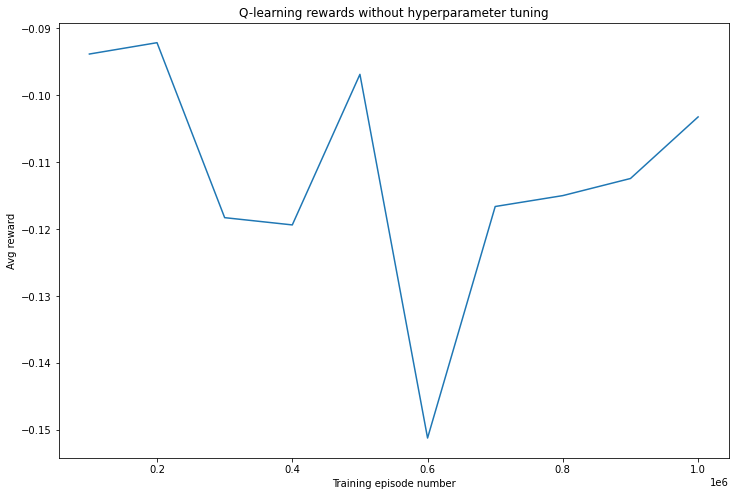

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(episodes, avg_rewards)
plt.title('Q-learning rewards without hyperparameter tuning')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');

Что-то так себе получилось за 1 млн эпизодов обучения. Казино нас обыгрывает. Средний reward около -0.1.

Подбираем гиперпараметры по очереди:

In [13]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 0.05]
epsilon = 0.05
gamma = 0.9

for alpha in alphas:
    avg_rewards, episodes, pi = train_Q_learning_model(env, alpha=alpha, epsilon=epsilon, gamma=gamma)
    print(f'alpha:{alpha}\t best reward:{avg_rewards.max()}')


alpha:1e-05	 best reward:-0.27644



alpha:0.0001	 best reward:-0.129605



alpha:0.001	 best reward:-0.089325



alpha:0.01	 best reward:-0.102005



alpha:0.05	 best reward:-0.08576


При больших alpha награда во время обучения сильно скачет, поэтому выберем alpha=0.001.

In [20]:
alpha = 1e-3
epsilons = [0.01, 0.1, 0.5, 0.75, 0.9, 0.95, 0.99]
gamma = 0.9

for epsilon in epsilons:
    avg_rewards, episodes, pi = train_Q_learning_model(env, alpha=alpha, epsilon=epsilon, gamma=gamma)
    print(f'epsilon:{epsilon}\t best reward:{avg_rewards.max()}')


epsilon:0.01	 best reward:-0.09527



epsilon:0.1	 best reward:-0.094855



epsilon:0.5	 best reward:-0.08555



epsilon:0.75	 best reward:-0.0789



epsilon:0.9	 best reward:-0.081715



epsilon:0.95	 best reward:-0.072155



epsilon:0.99	 best reward:-0.07573


Интересно, что epsilon получается таким большим и мы очень много исследуем в поисках оптимальной стратегии.

In [22]:
alpha = 1e-3
epsilon = 0.95
gammas = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 0.9, 0.95]

for gamma in gammas:
    avg_rewards, episodes, pi = train_Q_learning_model(env, alpha=alpha, epsilon=epsilon, gamma=gamma)
    print(f'gamma:{gamma}\t best reward:{avg_rewards.max()}')


gamma:0.01	 best reward:-0.049135



gamma:0.05	 best reward:-0.046485



gamma:0.1	 best reward:-0.05048



gamma:0.2	 best reward:-0.04559



gamma:0.5	 best reward:-0.037255



gamma:0.7	 best reward:-0.05341



gamma:0.8	 best reward:-0.069635



gamma:0.9	 best reward:-0.08279



gamma:0.95	 best reward:-0.091345


Потюнив gamma, мы получили стратегию, которая сравнима с нашей базовой стратегией с 19, 20 и 21 очком.

Но похоже оптимальное значение лежит где-то между 0.2 и 0.5.

In [24]:
alpha = 1e-3
epsilon = 0.95
gammas = [0.35, 0.4, 0.45, 0.55, 0.6]

for gamma in gammas:
    avg_rewards, episodes, pi = train_Q_learning_model(env, alpha=alpha, epsilon=epsilon, gamma=gamma)
    print(f'gamma:{gamma}\t best reward:{avg_rewards.max()}')


gamma:0.35	 best reward:-0.037675



gamma:0.4	 best reward:-0.03343



gamma:0.45	 best reward:-0.0385



gamma:0.55	 best reward:-0.04407



gamma:0.6	 best reward:-0.05257


Возьмем gamma = 0.4.

In [30]:
alpha = 1e-3
epsilon = 0.95
gamma = 0.4

avg_rewards, episodes, pi = train_Q_learning_model(
    env, alpha=alpha, epsilon=epsilon, gamma=gamma,
    train_episodes_num=2_000_000
)

Теперь даже чуть лучше, чем базовая стратегия. Avg reward = -0.03. Казино все равно выигрывает.

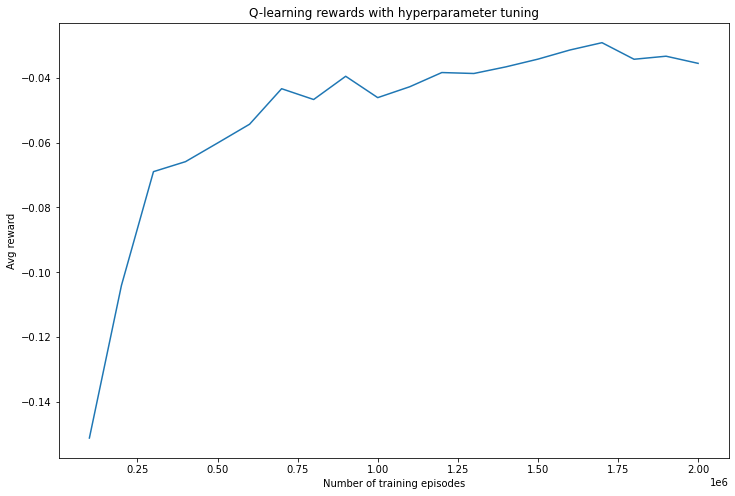

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(episodes, avg_rewards)
plt.title('Q-learning rewards with hyperparameter tuning')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');

In [32]:
env.close()

# Часть вторая, удвоенная

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [33]:
from gym.envs.toy_text.blackjack import *


class DoubleBlackjackEnv(BlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()
        
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.      
        elif action == 2:  # double: double wager, add a card to players hand, play out the dealers hand, and score
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -2.
            else:
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer))
                if self.natural and is_natural(self.player) and reward == 1.:
                    reward = 1.5
                else:
                    reward *= 2
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [34]:
env = DoubleBlackjackEnv(natural=True)

In [35]:
action_space_shape = [env.action_space.n]
observation_space_shape = [discrete_space.n for discrete_space in env.observation_space]
reward_range = [-2, 2]

У нас все уже почти готово, только поменяем функцию, генерирующую случайные значения Q:

In [36]:
def get_random_Q():
    Q = get_random_reward(reward_range, shape=observation_space_shape + action_space_shape)
    Q[np.arange(observation_space_shape[0]) > 21] = -1
    Q[np.arange(observation_space_shape[0]) > 21, ..., 2] = -2
    Q[np.arange(observation_space_shape[0]) == 21] = 1
    Q[np.arange(observation_space_shape[0]) == 21, ..., 2] = 2
    return Q

In [37]:
alpha = 1e-3
epsilon = 0.95
gamma = 0.4

avg_rewards, episodes, pi = train_Q_learning_model(
    env, alpha=alpha, epsilon=epsilon, gamma=gamma,
    train_episodes_num=2_000_000
)

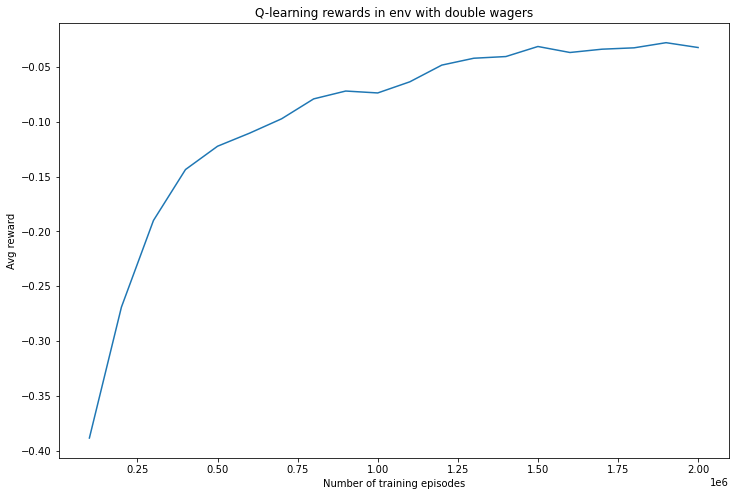

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(episodes, avg_rewards)
plt.title('Q-learning rewards in env with double wagers')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');

Получилось примерно так же, как и в окружении без удвоения ставок. Средняя награда = -0.03.

In [39]:
env.close()

# Часть третья, в главной роли — Дастин Хоффман

6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде.

In [43]:
from gym.envs.toy_text.blackjack import *

full_deck = np.tile(np.concatenate([np.arange(1, 10), np.repeat(10, 4)]), 4)

card_to_value = {
    1: -1,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 0,
    8: 0,
    9: 0,
    10: -1,
}

def get_idxs(s, a=None):
    if a is not None:
        return s[0], s[1], int(s[2]), s[3], a
    else:
        return s[0], s[1], int(s[2]), s[3]

class DoubleCountBlackjackEnv(BlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(41)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        
        self.deck = self.np_random.permutation(full_deck)
        self.card_idx = 0
        self.cnt = 0
        
        # Start the first game
        self.reset()
        
    def draw_card(self, count=True):
        card = self.deck[self.card_idx]
        self.card_idx += 1
        if count:
            self.cnt += card_to_value[card]
        return card
    
    def draw_hand(self, player_hand=True):
        return [self.draw_card(), self.draw_card(player_hand)]
        
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.      
        elif action == 2:  # double: double wager, add a card to players hand, play out the dealers hand, and score
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -2.
            else:
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card())
                reward = cmp(score(self.player), score(self.dealer))
                if self.natural and is_natural(self.player) and reward == 1.:
                    reward = 1.5
                else:
                    reward *= 2
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}
    
    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.cnt)
    
    def reset(self):
        if hasattr(self, 'dealer'):
            self.cnt += card_to_value[self.dealer[1]]
        
        if len(self.deck) - self.card_idx < 15:
            self.deck = self.np_random.permutation(full_deck)
            self.card_idx = 0
            self.cnt = 0
    
        self.dealer = self.draw_hand(player_hand=False)
        self.player = self.draw_hand()
        return self._get_obs()

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2

In [51]:
def get_random_Q():
    # инициализировать все случайными числами было плохой идеей,
    # обучается целую вечность, поэтому инициализация нулями везде, кроме конечных состояний
    Q = np.zeros(observation_space_shape + action_space_shape)
    Q[np.arange(observation_space_shape[0]) > 21] = -1
    Q[np.arange(observation_space_shape[0]) > 21, ..., 2] = -2
    Q[np.arange(observation_space_shape[0]) == 21] = 1
    Q[np.arange(observation_space_shape[0]) == 21, ..., 2] = 2
    return Q

In [44]:
env = DoubleCountBlackjackEnv(natural=True)

In [45]:
action_space_shape = [env.action_space.n]
observation_space_shape = [discrete_space.n for discrete_space in env.observation_space]
reward_range = [-2, 2]

In [52]:
alpha = 0.001
epsilon = 0.95
gamma = 0.4

avg_rewards, episodes, pi = train_Q_learning_model(
    env, alpha=alpha, epsilon=epsilon, gamma=gamma,
    train_episodes_num=10_000_000
)

In [55]:
print('max reward:', avg_rewards.max())

max reward: -0.005895


Даже с подсчетом карт казино нас обыгрывает. Награда осциллирует в районе -0.01.

В самом лучшем случае reward = -0.006.

Вывод: играть в казино - плохая затея.

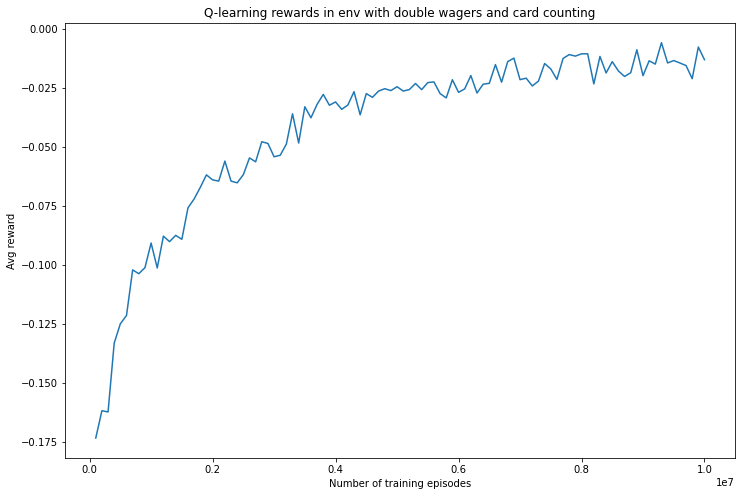

In [53]:
plt.figure(figsize=(12, 8))
plt.plot(episodes, avg_rewards)
plt.title('Q-learning rewards in env with double wagers and card counting')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');